## Relatório do TP 1 de algorítimos 2 ##

#### Autores: Lorenzo Carneiro Magalhães e Tomás Lacerda Muniz

##### Imports 

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from functions.utils import *
from functions.graham_scan import graham_scan
from functions.sweep_line_intersection import sweep_line_intersection
from functions.linear_separation import linear_separation
from functions.linear_classification import linear_classification
from functions.svm import classify_points_svm, metrics_svm
from functions.pca import apply_pca
from functions.datasets import *

Inicializamos todos os valores de cada variável com 0, essas variáveis serão usadas para rastrear o tempo de execução do nosso algorítimo

In [2]:
time_load_dataset = time_hull = time_intersection = time_linear_sep = time_linear_class = 0

### **Explicando o algorítimo através do banco de dados da Iris**

Inicializamos também os datasets em um dicionário no arquivo datasets.py para facilitar o acesso dos datasets. Cada função é personalizada para o dataset em questão


In [3]:
datasets

{'iris': <function functions.datasets.load_iris_()>,
 'wine': <function functions.datasets.load_wine_()>,
 'digits': <function functions.datasets.load_digits_()>,
 'breast_cancer': <function functions.datasets.load_breast_cancer_()>,
 'linnerud': <function functions.datasets.load_linnerud_()>,
 'diabetes': <function functions.datasets.load_diabetes_()>,
 'california_housing': <function functions.datasets.load_california_housing_()>,
 'mobile': <function functions.datasets.load_mobile()>,
 'diabetes2': <function functions.datasets.load_diabetes2()>,
 'pokemon': <function functions.datasets.load_pokemon()>}

Acompanhemos os testes na base de dados iris

Nesse exemplo faremos sem utilizar o dicionário, então reproduziremos a função manualmente

In [4]:
# Carregando a base de dados em pandas
init = time.perf_counter()

data = load_iris()
np.random.seed(42)
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

time_load_dataset += time.perf_counter() - init

Após carregar o banco de dados iris, vamos verificar se estes possuem mais do que 2 classes, caso tenha, deixamos apenas duas para realizar o classificador binário, e caso possua mais de duas dimensões, realizaremos um PCA para reduzir a dimensionalidade da matriz a fim de buscar as direções mais importantes

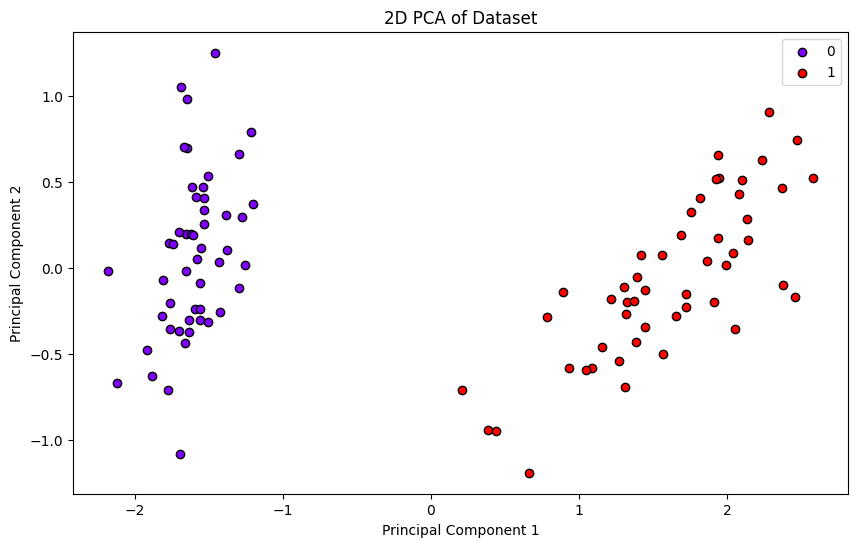

In [5]:
unique_classes = np.unique(df['target'])

if unique_classes.size > 2:
    # randomly select 2 classes
    selected_classes = np.random.choice(unique_classes, 2, replace=False)

    filtered_df = df[df['target'].isin(selected_classes)]

if df.shape[1] > 3: # 3 because of target
    # Extract data and labels from the filtered dataframe
    X_filtered = filtered_df.drop('target', axis=1).values
    y_filtered = filtered_df['target'].values

    # Apply PCA and visualize the result
    reduced_data = apply_pca(X_filtered, y_filtered, target_names=selected_classes, visualize = True)


Note que agora pegamos um dataset como o da iris e reduzimos a dimensionalidade dele para 2, isso é importante para que possamos visualizar os dados em um gráfico e por consequência traçar a envoltória

\
Aqui separamos os dados em base para testes e base para treinamento, a base de treinamento será usada para traçar a envoltória e a base de testes para verificar se os pontos estão dentro ou fora da envoltória

In [6]:
reduced_df = pd.DataFrame(reduced_data, columns=['x', 'y'])
reduced_df['target'] = y_filtered

# TRAINING PHASE

# select 70% of the data for training and 30% for testing
train_df = reduced_df.sample(frac=0.7)

# grab 30% of the data for testing
test_df = reduced_df.drop(train_df.index)

# reset the index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

X1 = train_df[train_df['target'] == selected_classes[0]][['x', 'y']]
X2 = train_df[train_df['target'] == selected_classes[1]][['x', 'y']]

Segue a explicação do nosso algorítimo de graham scan para encontrar a envoltória convexa

---

##### **Função graham_scan**

Aqui foi usado o algorítimo de graham scan para encontrar a envoltória convexa, a função recebe uma lista de pontos e retorna a lista de pontos que forma a envoltória convexa.

A função faz isso da seguinte forma:

Inicialmente testamos para ver se a lista possue pelomenos 3 pontos, caso não possua é impossível fazer uma envoltória.

Então encontramos o ponto âncora, que é o ponto com a menor coordenada Y. Se houver empates o com a menor coordenada em X é escolinho.

Organizamos os pontos baseados em seu ângulo polar com o ponto âncora.

Criamos uma pilha para armazenar os pontos da envoltória, e colocamos os 3 primeiros pontos da lista nela.

O loop while interno remove pontos da pilha que não formam uma curva à esquerda (ou seja, não fazem parte do invólucro convexo) quando considerados junto com o ponto atual em análise.

E então retornamos a pilha.

In [7]:
# making the hull for each
hull1, time1_ = graham_scan([Point(row['x'], row['y']) for _, row in X1.iterrows()])
hull2, time2_ = graham_scan([Point(row['x'], row['y']) for _, row in X2.iterrows()])

# Armazenando tempo
time_hull += time1_
time_hull += time2_

##### **Função points_to_segments**

A função points_to_segments percorre os pontos de uma lista de pontos e cria uma lista de segmentos através de um loop.

Usando a função $(hull[(i+1) \mod len(hull)])$ garantimos que o ciclo se fecha.

Retorna a lista de segmentos

In [8]:
all_segments1 = points_to_segments([Point(row['x'], row['y']) for _, row in X1.iterrows()])
all_segments2 = points_to_segments([Point(row['x'], row['y']) for _, row in X2.iterrows()])

##### **Função sweep_line_intersection**

O código define a função sweep_line_intersection que verifica se há interseções entre duas listas de segmentos, segments1 e segments2.

A função retorna se há intersecções e as interseções encontradas.

Para fazer isso, a função utiliza o algoritmo de varredura linear.

Primeiramente, pontos de início e fim de cada segmento são adicionados a uma lista de eventos, que é então organizada em uma heap com base nas coordenadas x. 

A função então verifica, ponto por ponto, se há interseções entre os segmentos ativos de segments1 e segments2. 

Se uma interseção for encontrada, a função retorna True e a lista de segmentos, caso contrário, ela continua até que todos os eventos sejam processados e, finalmente, retorna False se nenhuma interseção for encontrada e uma lista vazia.

In [9]:
intersection = True

(intersection, collided_segments), time_ = sweep_line_intersection(all_segments1, all_segments2)

time_intersection += time_

if intersection:
    print("Intersects\n")
    print("Removing intersect points...")

    counter = 0
    while intersection:
        (intersection, collided_segments), time_ = sweep_line_intersection(all_segments1, all_segments2)

        time_intersection += time_
        for segment1, segment2 in collided_segments:
            for s in all_segments1:
                if s == segment1 or s == segment2:
                    all_segments1.remove(s)
                    
            for s in all_segments2:
                if s == segment1 or s == segment2:
                    all_segments2.remove(s)

        counter += 1

    print(f'Number of iterations removing intersect points: {counter}')

print("Not intersects")

Not intersects


##### **Função linear_separation**

A função linear_separation determina uma linha reta que separa os pontos de dois fechos convexos (hull1 e hull2).

Ela começa encontrando os pontos mais próximos entre os dois fechos usando a função find_closest_points. 

Depois, determina o ponto médio entre esses dois pontos. 

O objetivo é encontrar uma linha perpendicular à linha formada pelos dois pontos mais próximos. 

Se a linha entre p1 e p2 não for vertical, o coeficiente angular da linha perpendicular é calculado como o negativo do inverso do coeficiente angular de p1 e p2. 

Se for vertical, o coeficiente angular da linha perpendicular é definido como zero. 

Finalmente, a equação da linha é formulada no formato ax + by + c = 0, usando o coeficiente angular da linha perpendicular e o ponto médio. 

A função retorna os coeficientes a, b, e c dessa equação, juntamente com as coordenadas x e y do ponto médio.

In [10]:
(a, b, a_p1, a_p2), time_ = linear_separation(hull1, hull2)

time_linear_sep += time_

##### **Função classify_points_svm**

A função classify_points_svm usa uma SVM com um kernel linear para classificar pontos. 

Ela divide os pontos de entrada em conjuntos de treinamento e de teste. 

Depois, treina a SVM no conjunto treinamento e faz as previsões no conjunto teste. 

As métricas de acurácia, precisão, recall e pontuação F1 são calculadas com base nas previsões. 

Se o parâmetro plot_boundary for verdadeiro, a função plota os pontos e a fronteira de decisão da SVM. 

Finalmente, a função retorna as métricas calculadas e os coeficientes da linha que representa a fronteira de decisão.

In [11]:
clf = classify_points_svm(train_df[['x', 'y']].values, train_df['target'].values)

Fase de testes é onde testaremos a eficiência do nosso algorítimo

In [12]:
# TESTING PHASE
X = test_df[['x', 'y']].values
y = test_df['target'].values

# For eventual plotting
# X = train_df[['x', 'y']].values
# y = train_df['target'].values

acc_svm, precision_svm, recall_svm, f1_svm, ab_svm = metrics_svm(X, y, clf)

##### **Função linear_classification**

A função linear_classification separa as duas classes com uma linha reta. 

Ela verifica se cada ponto está acima ou abaixo da linha e faz uma previsão da classe com base no posicionamento relativo a linha. 

Após classificar todos os pontos, a função avalia a precisão dessas previsões comparando-as com os rótulos verdadeiros, usando as métricas de acurácia, precisão, recall e pontuação F1. 

Ela retorna as métricas de avaliação e os coeficientes da linha reta.


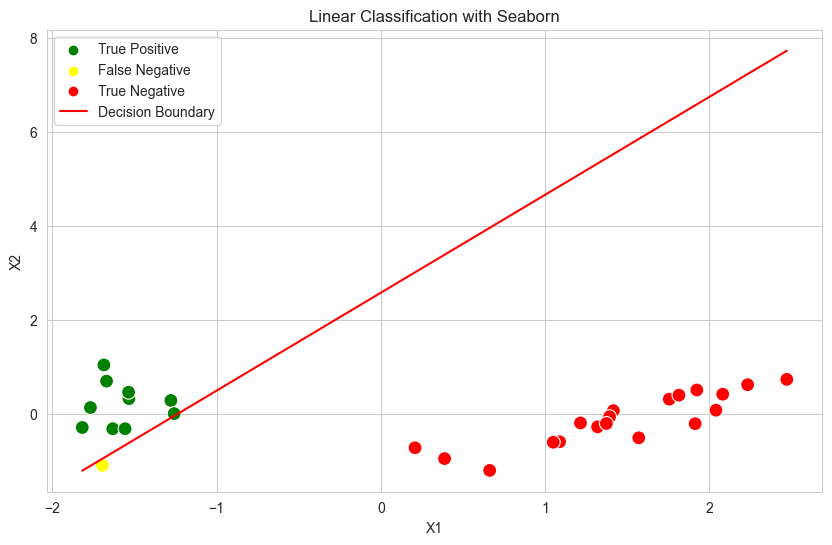

In [13]:
(acc, precision, recall, f1), time_ = linear_classification(X, y, a, b, selected_classes[0], selected_classes[1])
time_linear_class += time_

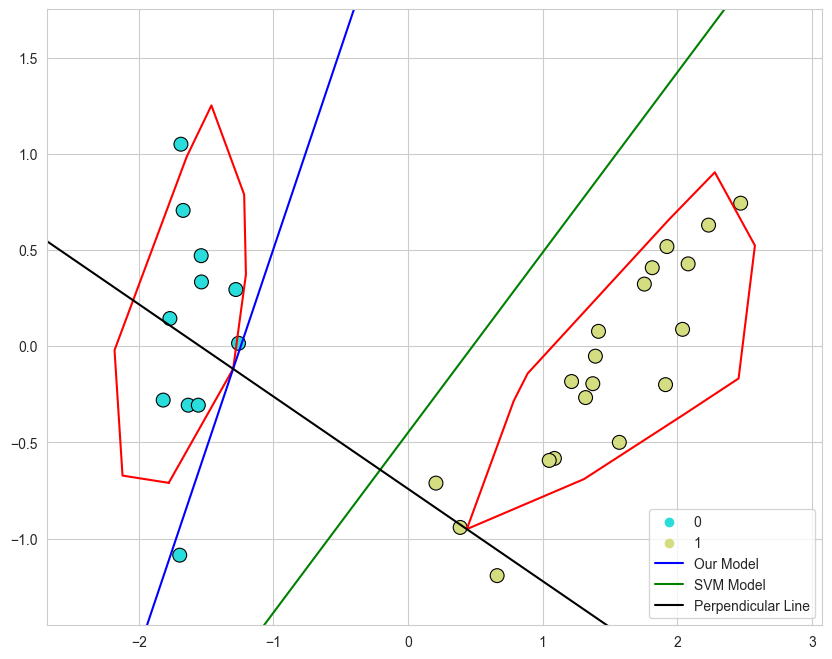

<Figure size 640x480 with 0 Axes>

In [14]:
# Plotting the data
plot_grid_hulls_separation(X, y, hull1, hull2, (a, b), ab_svm, (a_p1, a_p2), save=True, filename=f"graphs/dataset_iris.png")

#### **Metricas de avaliação**

In [15]:
time_linear_class += time_
print(f"METRICS: Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
print(f"METRICS SVM: Accuracy: {acc_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}")
print(f"Time hull: {time_hull}")
print(f"Time intersection: {time_intersection}")
print(f"Time linear separation: {time_linear_sep}")
print(f"Time linear classification: {time_linear_class}")

METRICS: Accuracy: 0.9666666666666667, Precision: 1.0, Recall: 0.9090909090909091, F1 Score: 0.9523809523809523
METRICS SVM: Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Time hull: 0.00027259999999973417
Time intersection: 0.0010423999999997768
Time linear separation: 0.00010790000000016065
Time linear classification: 0.44013400000000047


### Código generalizado

--------------------------------------------------
Dataset: iris
--------------------------------------------------
Not intersects


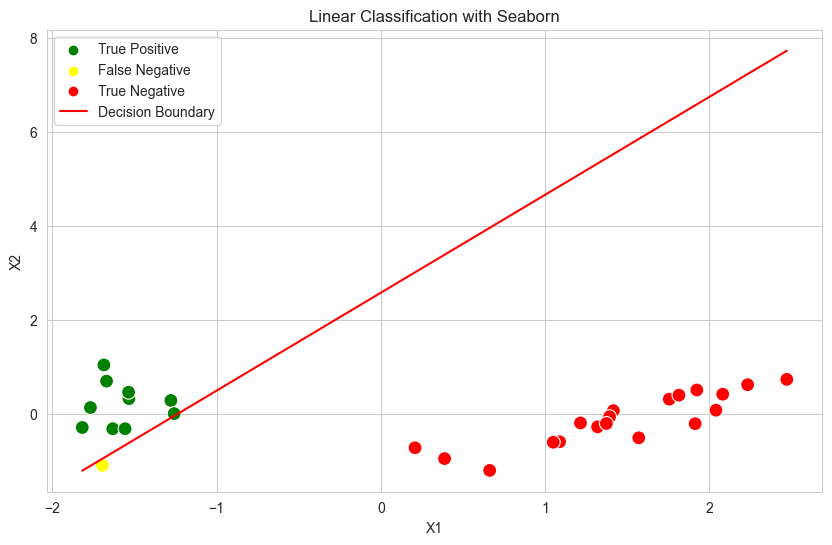

METRICS: Accuracy: 0.9666666666666667, Precision: 1.0, Recall: 0.9090909090909091, F1 Score: 0.9523809523809523
METRICS SVM: Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0


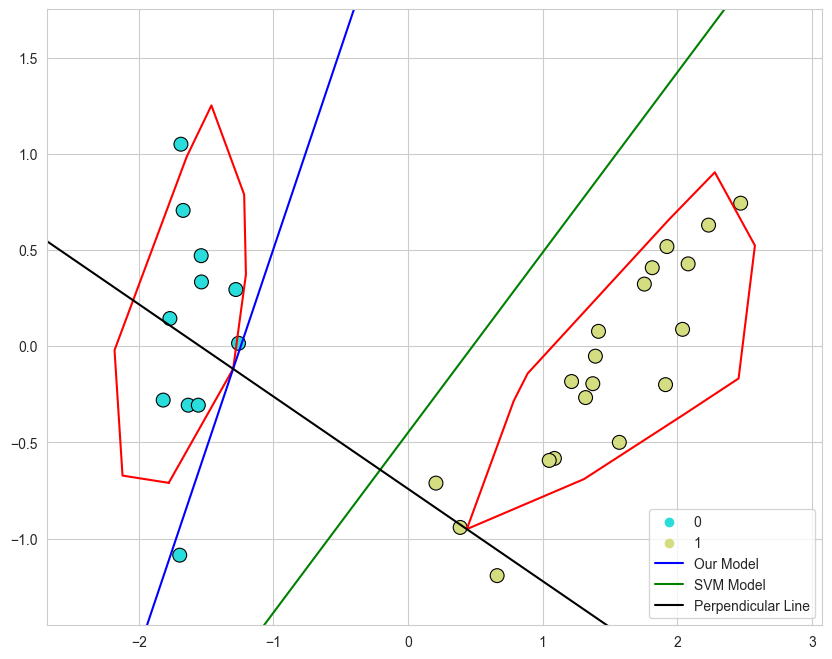




--------------------------------------------------
Dataset: wine
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


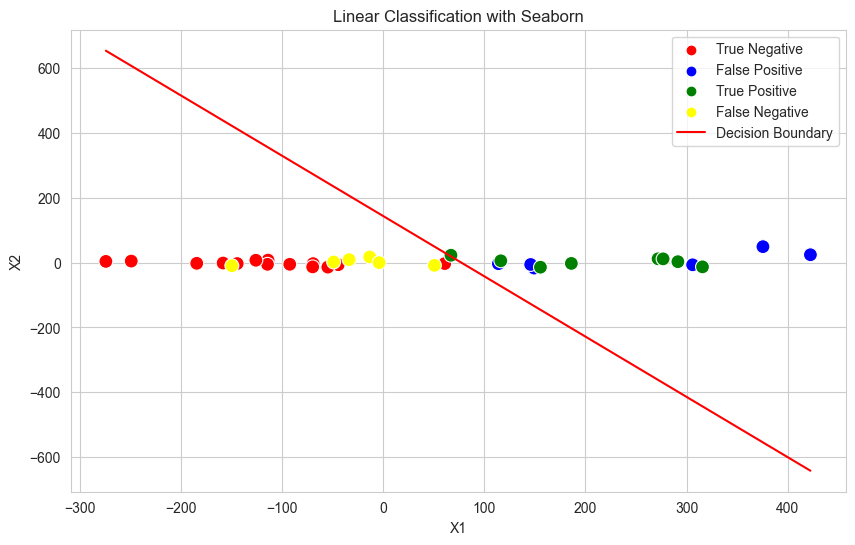

METRICS: Accuracy: 0.6666666666666666, Precision: 0.5714285714285714, Recall: 0.5714285714285714, F1 Score: 0.5714285714285714
METRICS SVM: Accuracy: 0.6944444444444444, Precision: 0.6888544891640866, Recall: 0.698051948051948, F1 Score: 0.6884343036978757


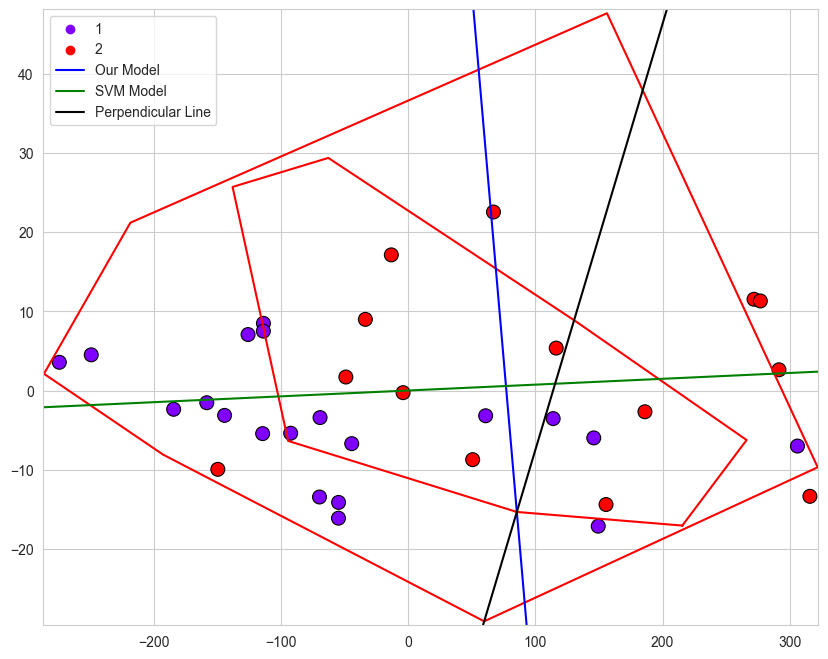




--------------------------------------------------
Dataset: digits
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


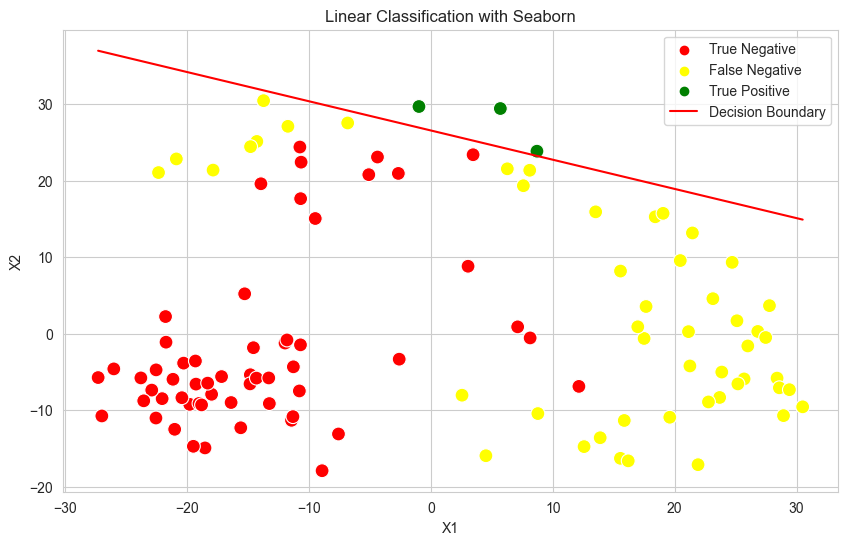

METRICS: Accuracy: 0.5504587155963303, Precision: 1.0, Recall: 0.057692307692307696, F1 Score: 0.1090909090909091
METRICS SVM: Accuracy: 0.8440366972477065, Precision: 0.8439824205544286, Recall: 0.8432860998650472, F1 Score: 0.843562684677079


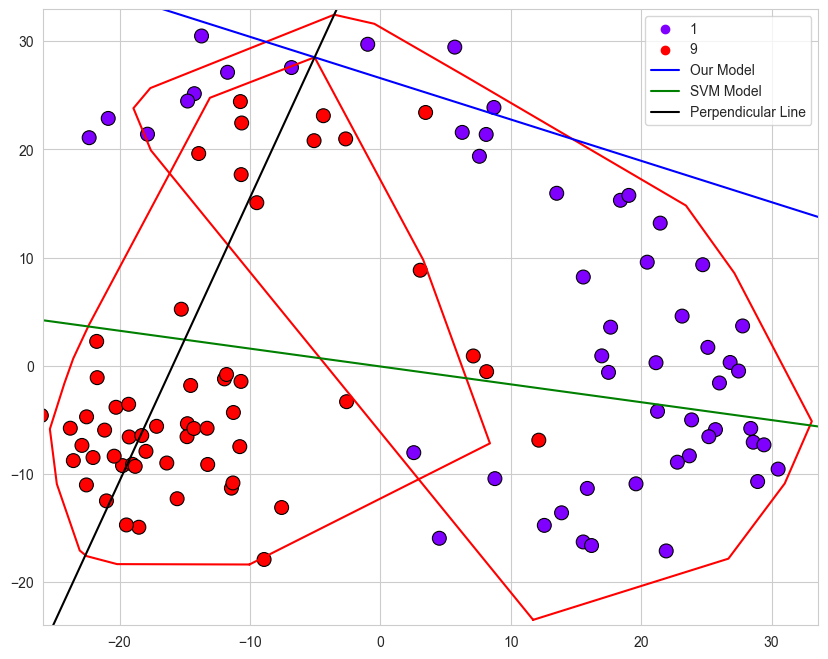




--------------------------------------------------
Dataset: breast_cancer
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


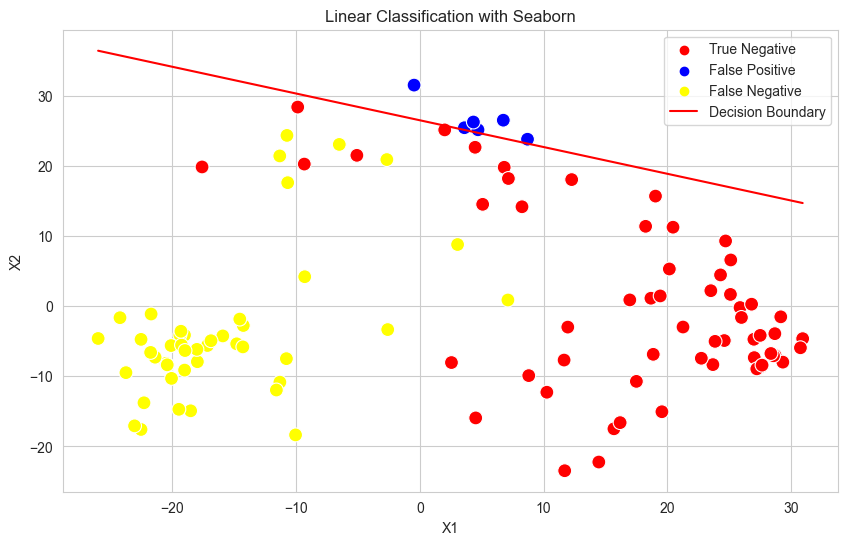

METRICS: Accuracy: 0.5321100917431193, Precision: 0.0, Recall: 0.0, F1 Score: 0
METRICS SVM: Accuracy: 0.926605504587156, Precision: 0.9272374911909795, Recall: 0.9210069444444444, F1 Score: 0.9237762237762237


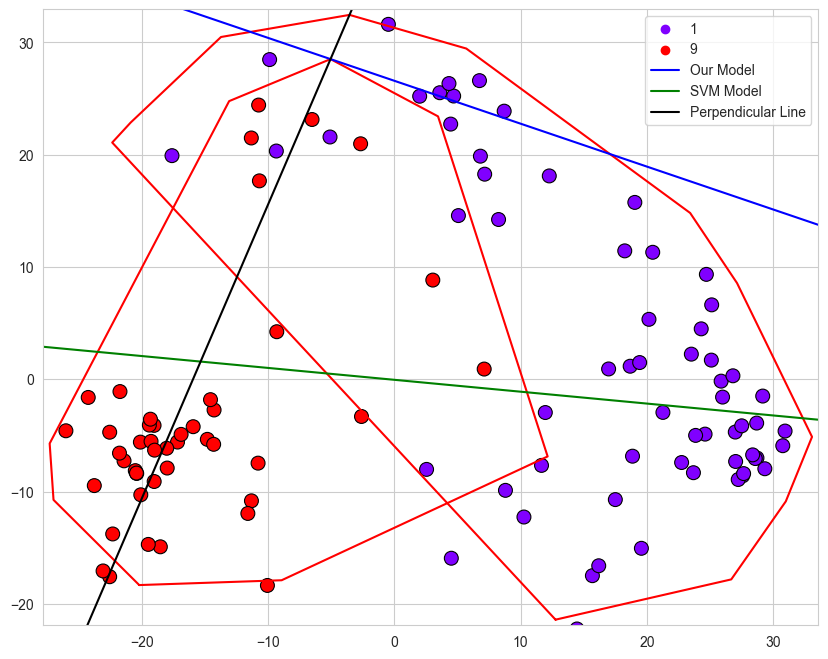




--------------------------------------------------
Dataset: linnerud
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


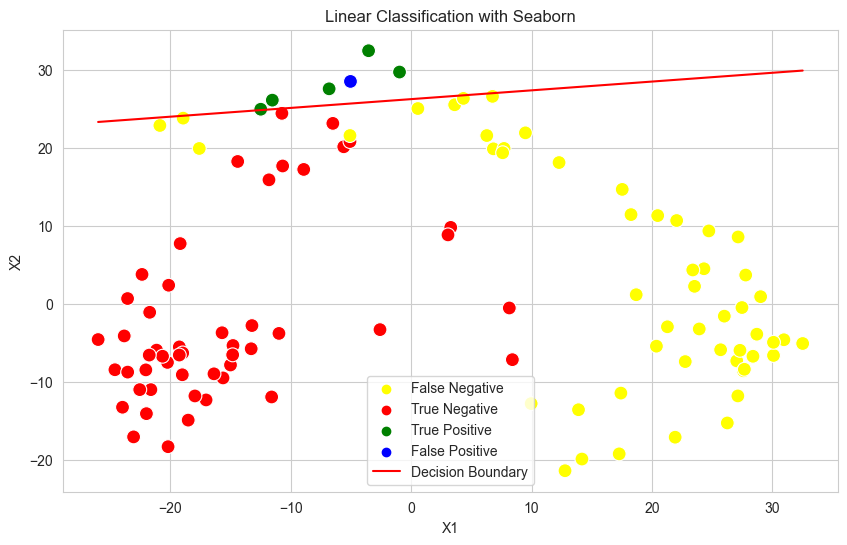

METRICS: Accuracy: 0.5137614678899083, Precision: 0.8333333333333334, Recall: 0.08771929824561403, F1 Score: 0.15873015873015872
METRICS SVM: Accuracy: 0.8807339449541285, Precision: 0.884866163349348, Recall: 0.8783738191632928, F1 Score: 0.8797215856039385


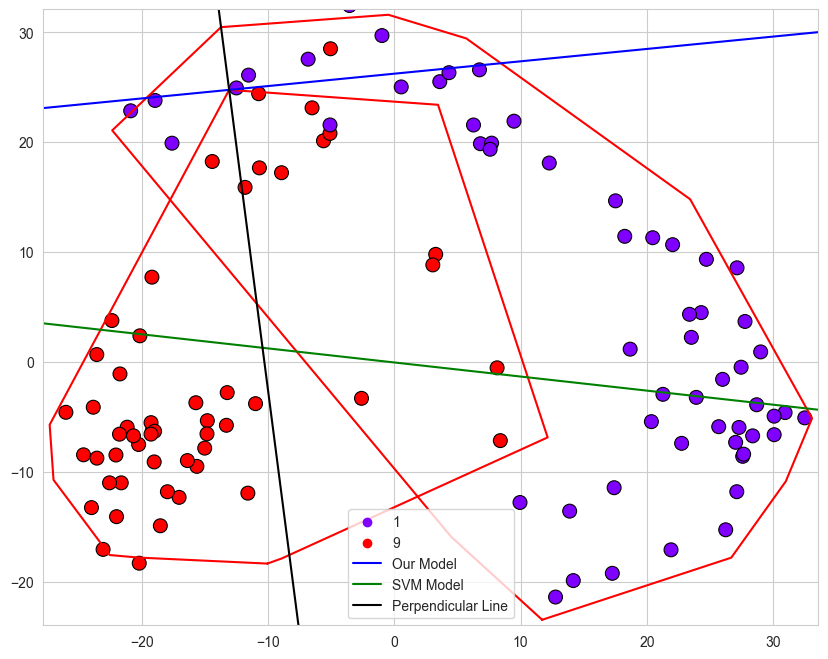




--------------------------------------------------
Dataset: diabetes
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


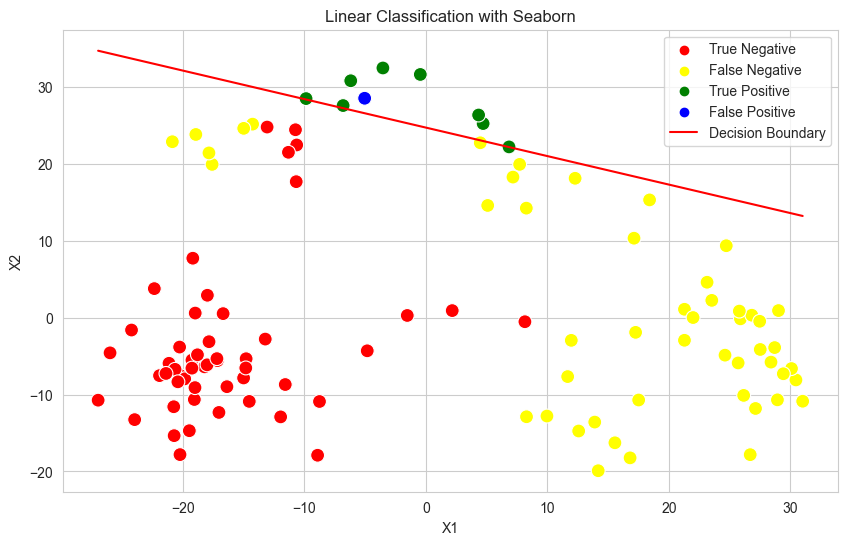

METRICS: Accuracy: 0.5412844036697247, Precision: 0.8888888888888888, Recall: 0.14035087719298245, F1 Score: 0.24242424242424243
METRICS SVM: Accuracy: 0.908256880733945, Precision: 0.9091981132075472, Recall: 0.9097503373819162, F1 Score: 0.9082491582491582


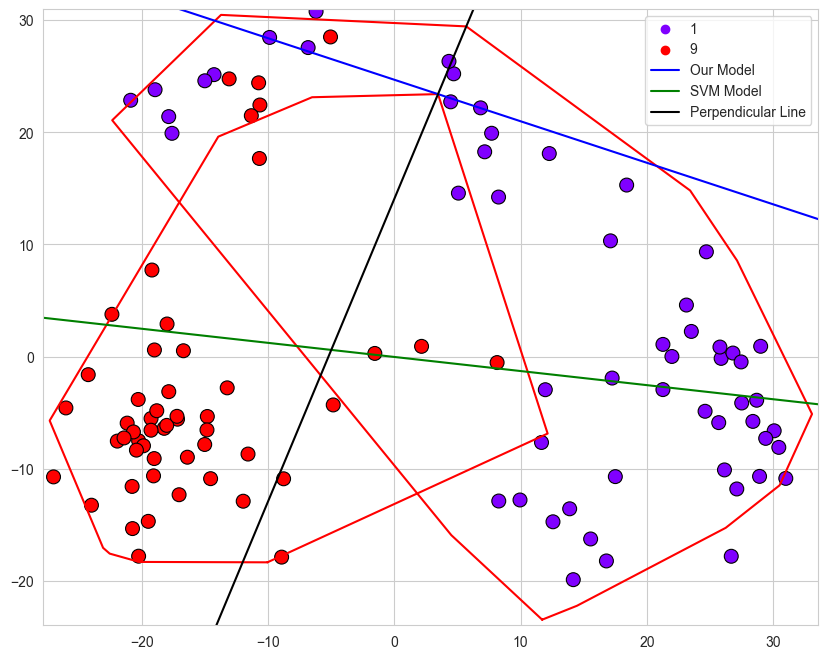




--------------------------------------------------
Dataset: california_housing
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


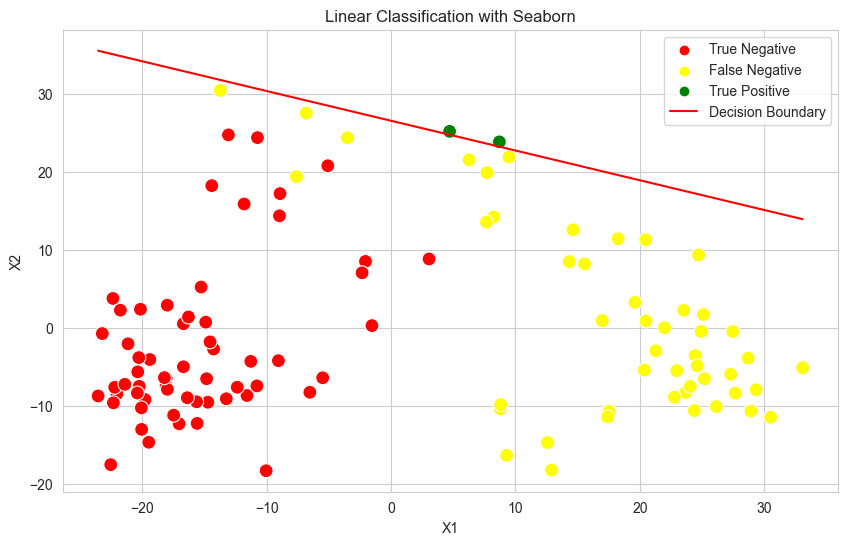

METRICS: Accuracy: 0.5596330275229358, Precision: 1.0, Recall: 0.04, F1 Score: 0.07692307692307693
METRICS SVM: Accuracy: 0.9357798165137615, Precision: 0.9385964912280702, Recall: 0.9406779661016949, F1 Score: 0.9357581880946366


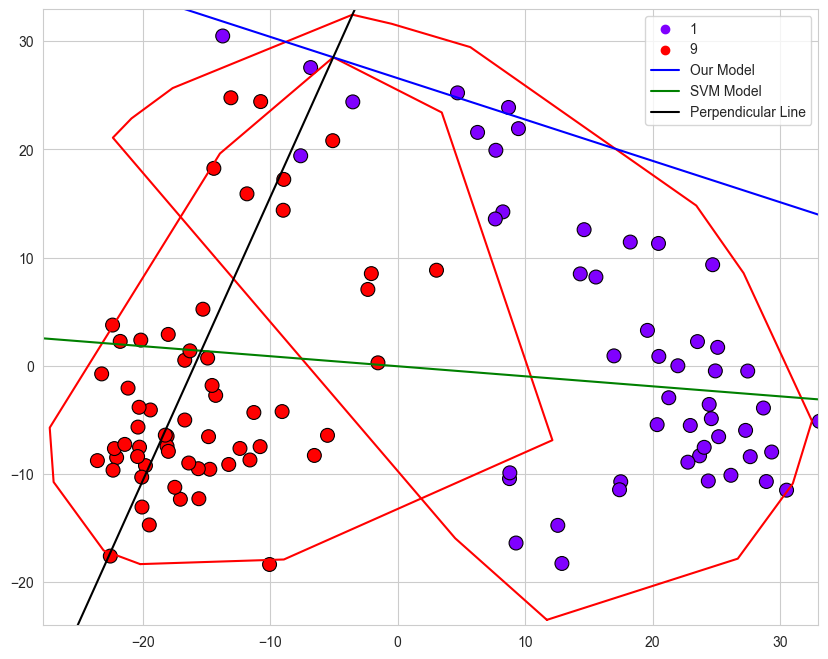




--------------------------------------------------
Dataset: mobile
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


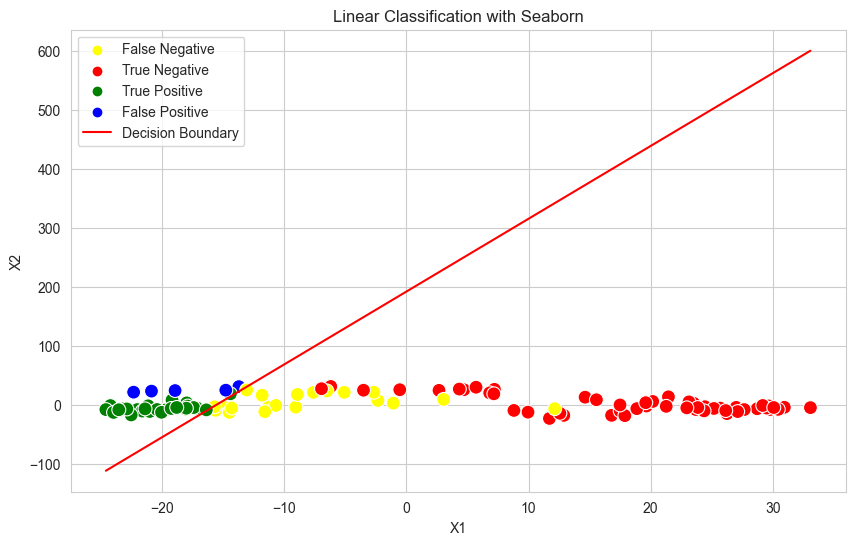

METRICS: Accuracy: 0.7706422018348624, Precision: 0.8611111111111112, Recall: 0.6078431372549019, F1 Score: 0.7126436781609194
METRICS SVM: Accuracy: 0.8990825688073395, Precision: 0.8991525423728814, Recall: 0.8980730223123732, F1 Score: 0.8985360074468984


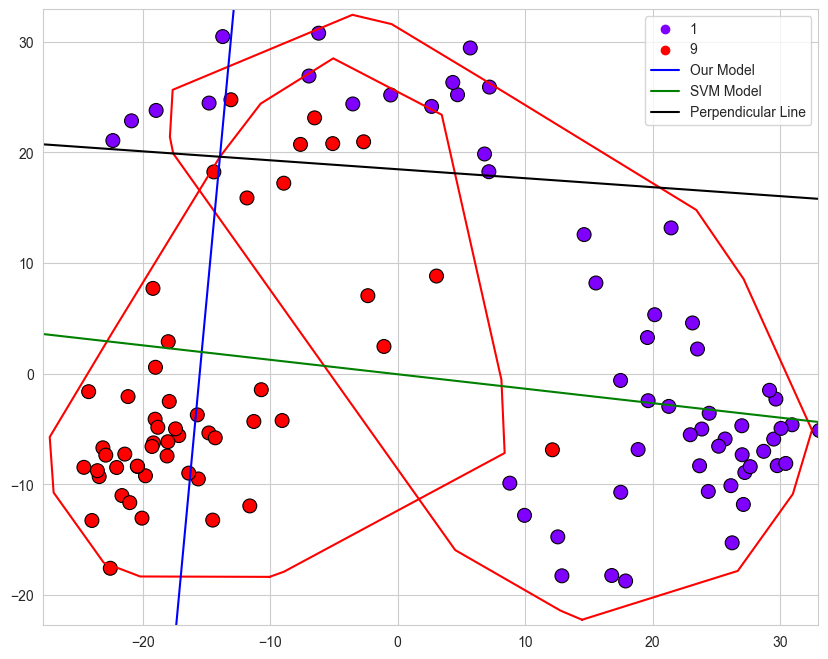




--------------------------------------------------
Dataset: diabetes2
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


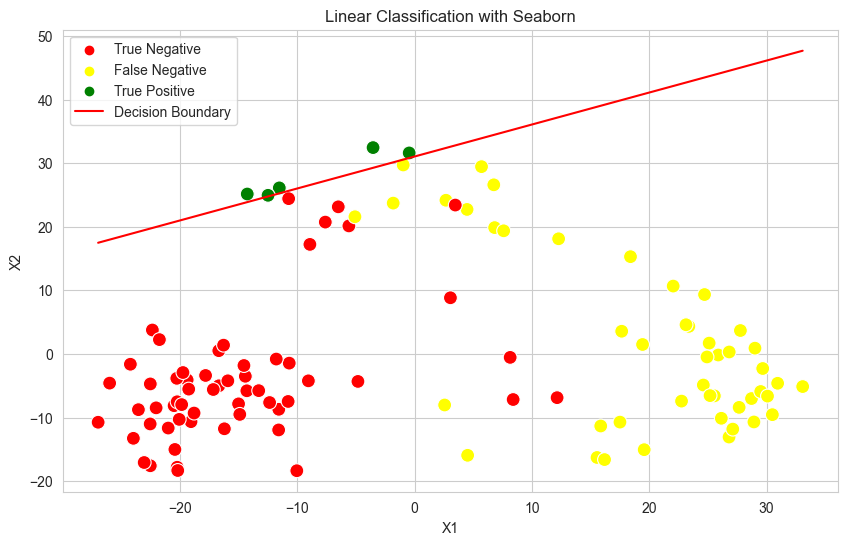

METRICS: Accuracy: 0.5779816513761468, Precision: 1.0, Recall: 0.09803921568627451, F1 Score: 0.17857142857142855
METRICS SVM: Accuracy: 0.8899082568807339, Precision: 0.8902356902356903, Recall: 0.8918187964841109, F1 Score: 0.8898247978436657


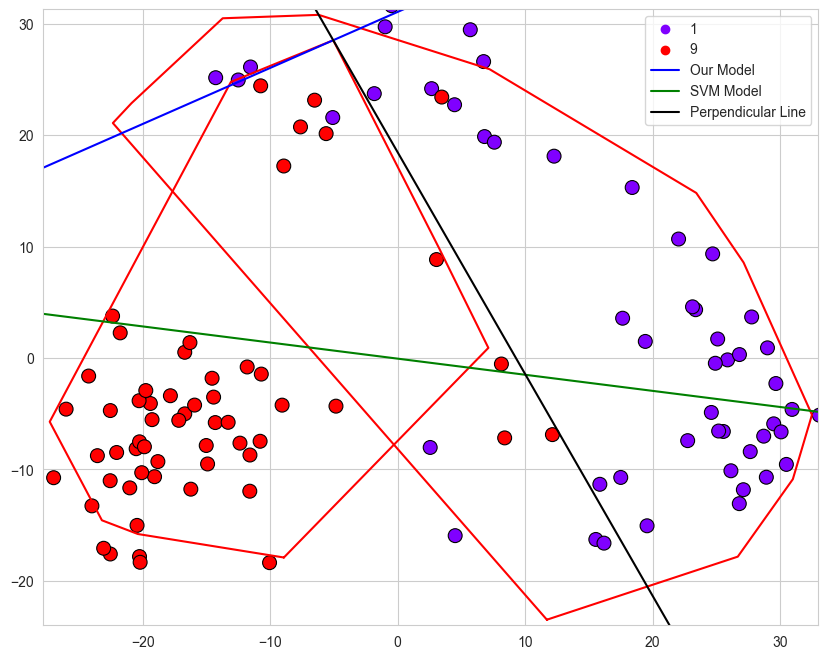




--------------------------------------------------
Dataset: pokemon
--------------------------------------------------
Intersects

Removing intersect points...
Number of iterations removing intersect points: 2
Not intersects


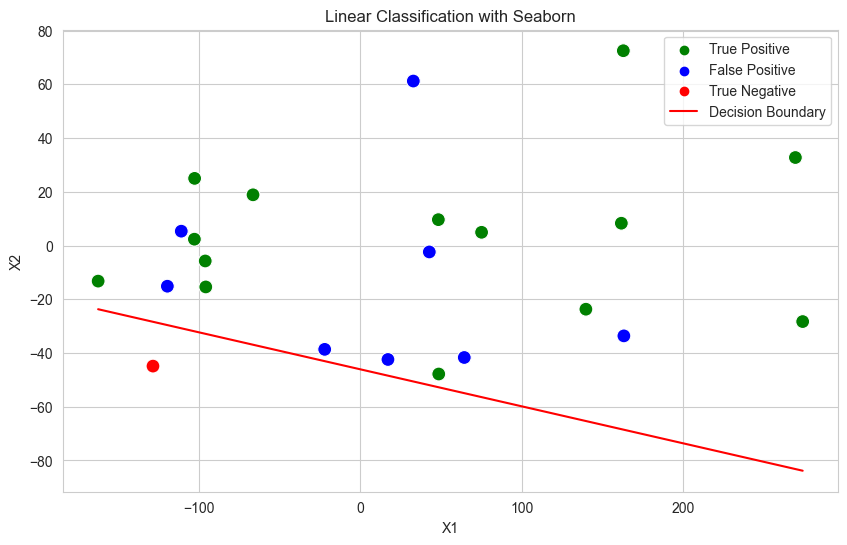

METRICS: Accuracy: 0.6521739130434783, Precision: 0.6363636363636364, Recall: 1.0, F1 Score: 0.7777777777777778
METRICS SVM: Accuracy: 0.6956521739130435, Precision: 0.6791666666666667, Recall: 0.6706349206349207, F1 Score: 0.6734279918864097


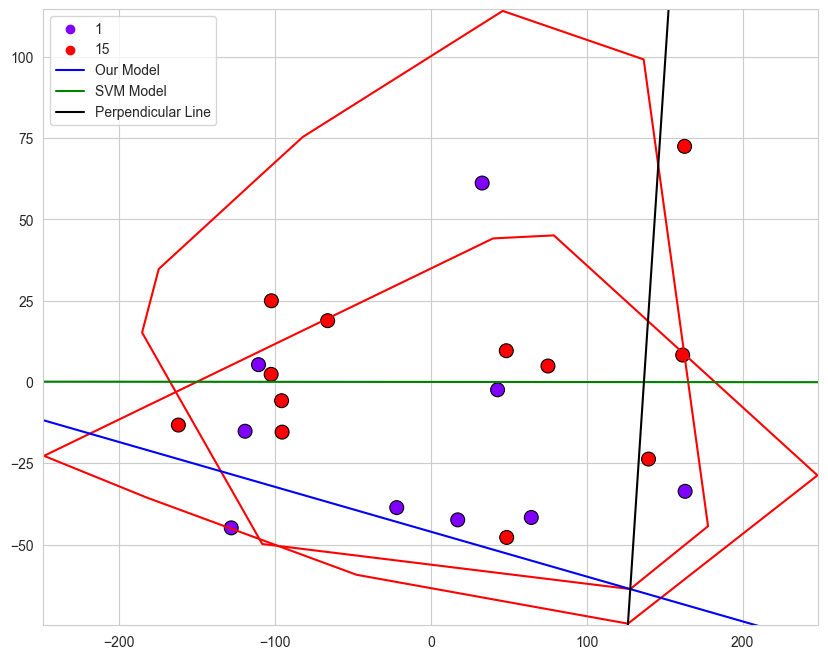




Time load dataset: 0.14933369999999968
Time hull: 0.010379600000021583
Time intersection: 0.3846275999999591
Time linear separation: 0.001315100000027769
Time linear classification: 2.042119999999983


In [19]:
np.random.seed(42)

time_load_dataset = time_hull = time_intersection = time_linear_sep = time_linear_class = 0

for d_name, d in datasets.items():

    print('-'*50)
    print(f"Dataset: {d_name}")
    print('-'*50)

    # load the dataset

    init = time.perf_counter()
    df = d()
    time_load_dataset += time.perf_counter() - init

    # verify if it is a binary classification problem
    unique_classes = np.unique(df['target'])
    if unique_classes.size > 2:
        # randomly select 2 classes
        selected_classes = np.random.choice(unique_classes, 2, replace=False)

        filtered_df = df[df['target'].isin(selected_classes)]

    if df.shape[1] > 3: # 3 because of target
        # Extract data and labels from the filtered dataframe
        X_filtered = filtered_df.drop('target', axis=1).values
        y_filtered = filtered_df['target'].values

        # Apply PCA and visualize the result
        reduced_data = apply_pca(X_filtered, y_filtered, target_names=selected_classes)

    reduced_df = pd.DataFrame(reduced_data, columns=['x', 'y'])
    reduced_df['target'] = y_filtered

    # select 70% of the data for training and 30% for testing
    train_df = reduced_df.sample(frac=0.7)

    # grab 30% of the data for testing
    test_df = reduced_df.drop(train_df.index)

    # reset the index
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # TRAINING PHASE

    X1 = train_df[train_df['target'] == selected_classes[0]][['x', 'y']]
    X2 = train_df[train_df['target'] == selected_classes[1]][['x', 'y']]

    # making the hull for each
    hull1, time1_ = graham_scan([Point(row['x'], row['y']) for _, row in X1.iterrows()])
    hull2, time2_ = graham_scan([Point(row['x'], row['y']) for _, row in X2.iterrows()])

    time_hull += time1_
    time_hull += time2_

    all_segments1 = points_to_segments([Point(row['x'], row['y']) for _, row in X1.iterrows()])
    all_segments2 = points_to_segments([Point(row['x'], row['y']) for _, row in X2.iterrows()])

    intersection = True

    (intersection, collided_segments), time_ = sweep_line_intersection(all_segments1, all_segments2)

    time_intersection += time_

    if intersection:
        print("Intersects\n")
        print("Removing intersect points...")

        counter = 0
        while intersection:
            (intersection, collided_segments), time_ = sweep_line_intersection(all_segments1, all_segments2)

            time_intersection += time_
            for segment1, segment2 in collided_segments:
                for s in all_segments1:
                    if s == segment1 or s == segment2:
                        all_segments1.remove(s)
                        
                for s in all_segments2:
                    if s == segment1 or s == segment2:
                        all_segments2.remove(s)

            counter += 1

        print(f'Number of iterations removing intersect points: {counter}')

    print("Not intersects")

    # ax + by + c = 0
    (a, b, a_p1, a_p2), time_ = linear_separation(hull1, hull2)

    time_linear_sep += time_

    clf = classify_points_svm(train_df[['x', 'y']].values, train_df['target'].values)

    # TESTING PHASE
    
    # X = train_df[['x', 'y']].values
    # y = train_df['target'].values

    X = test_df[['x', 'y']].values
    y = test_df['target'].values

    acc_svm, precision_svm, recall_svm, f1_svm, ab_svm = metrics_svm(X, y, clf)

    (acc, precision, recall, f1), time_ = linear_classification(X, y, a, b, selected_classes[0], selected_classes[1], plot=True)

    time_linear_class += time_

    print(f"METRICS: Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    print(f"METRICS SVM: Accuracy: {acc_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}")

    # Plotting the data
    plot_grid_hulls_separation(X, y, hull1, hull2, (a, b), ab_svm, (a_p1, a_p2), save=False, plot=True, filename=f"graphs/dataset_{d_name}.png")

    print('\n\n')

print(f"Time load dataset: {time_load_dataset}")
print(f"Time hull: {time_hull}")
print(f"Time intersection: {time_intersection}")
print(f"Time linear separation: {time_linear_sep}")
print(f"Time linear classification: {time_linear_class}")

---

### Explicando os gráficos e mostrando as diferenças entre treino e teste

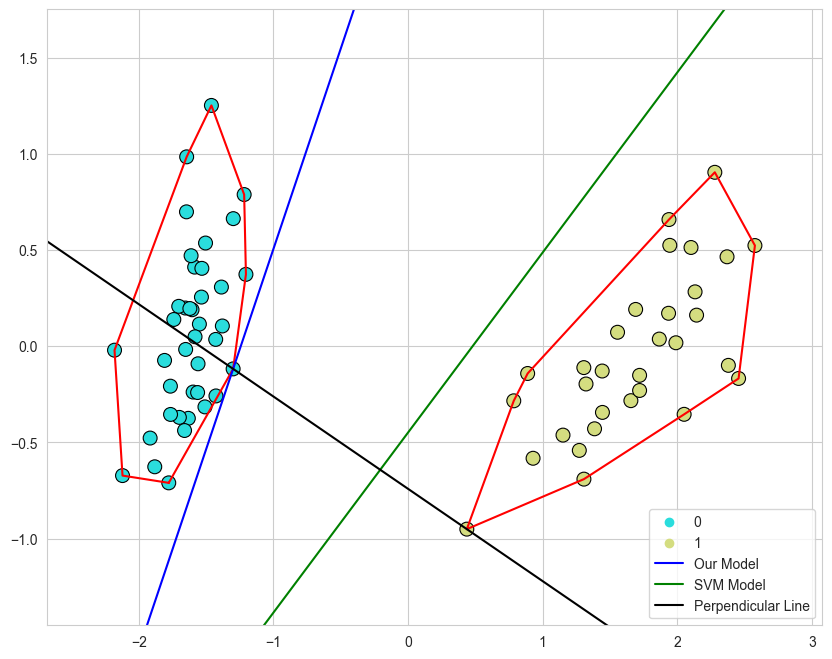

In [17]:
from IPython.display import Image
Image(filename="images/graph train.png")

A imagem acima representa o gráfico referente a iris e aqui explicarei um pouco melhor como está funcionando

A envoltória convexa é dada pela linha vermelha.

A linha entre os dois pontos mais próximos é dada pela linha preta

O nosso modelo traça perpendicularmente a linha azul 

A linha verde é uma linha de SVM para comparação


Perceba que: por mais que pareça inicialmente que a linha não está perpendicular, ela de fato está! Isso ocorre pois a escala do gráfico não está correta, mas se você olhar para os valores dos coeficientes da linha, verá que eles são de fato perpendiculares



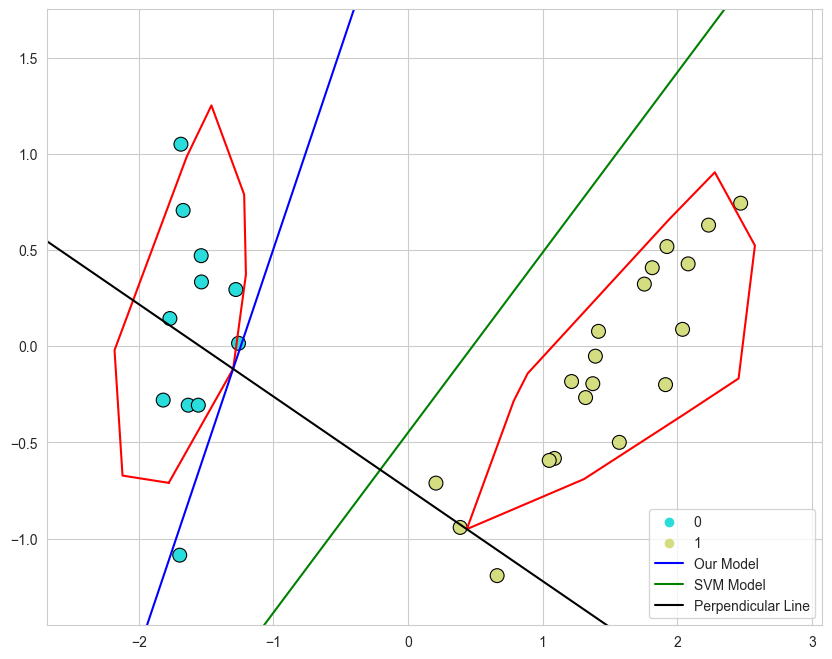

In [18]:
Image(filename="images/graph test.png")

Aqui temos o gráfico de teste, onde podemos ver pontos fora da envoltória convexa, entretanto podemos ver também a precisão do modelo que consegue corretamente classificar a grande maioria dos pontos.